# Install Spark

The below comands will install spark locally in our colab instance.

In [1]:
# Colab: Java + PySpark
#!apt-get update -y && apt-get install -y openjdk-17-jdk
#!pip install -q pyspark==3.5.4
import os, subprocess
os.environ["JAVA_HOME"] = subprocess.check_output(
    "readlink -f /usr/bin/java | sed 's:/bin/java::'", shell=True
).decode().strip()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("adult-mllib").getOrCreate()
print("Spark:", spark.version)

Spark: 3.5.1


## Exercise Overview
In this exercise we will play with Spark [Datasets & Dataframes](https://spark.apache.org/docs/latest/sql-programming-guide.html#datasets-and-dataframes), some [Spark SQL](https://spark.apache.org/docs/latest/sql-programming-guide.html#sql), and build a couple of binary classifiaction models using [Spark ML](https://spark.apache.org/docs/latest/ml-guide.html) (with some [MLlib](https://spark.apache.org/mllib/) too).
<br><br>
The set up and approach will not be too dissimilar to the standard type of approach you might do in [Sklearn](http://scikit-learn.org/stable/index.html). Spark has matured to the stage now where for 90% of what you need to do (when analysisng tabular data) should be possible with Spark dataframes, SQL, and ML libraries. This is where this exerise is mainly trying to focus.  
<br>

#### Links & References

Some useful links and references of sources used in creating this exercise:

**Note**: Right click and open as new tab!
<br>
1. [Latest Spark Docs](https://spark.apache.org/docs/latest/index.html)
1. [Databricks Homepage](https://databricks.com/)
1. [Databricks Community Edition FAQ](https://databricks.com/product/faq/community-edition)
1. [Databricks Self Paced Training](https://databricks.com/training-overview/training-self-paced)
1. [Databricks Notebook Guide](https://docs.databricks.com/user-guide/notebooks/index.html)
1. [Databricks Binary Classification Tutorial](https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html#binary-classification)

#### Get Data

Here we will pull in some sample data from the UCI data repository.

Feel free to adapt this notebook later to play around with a different dataset if you like (all available are listed in a cell below).

In [2]:
try:
    spark
except NameError:
    from pyspark.sql import SparkSession
    spark = (
        SparkSession.builder
        .master("local[*]")
        .appName("adult-colab")
        .getOrCreate()
    )
import pandas as pd
cols = [
    "age","workclass","fnlwgt","education","education_num","marital_status",
    "occupation","relationship","race","sex","capital_gain","capital_loss",
    "hours_per_week","native_country","income"
]
pdf = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None,
    names=cols,
    skipinitialspace=True,
    na_values=["?", " ?"]
)
for c in pdf.select_dtypes(include="object").columns:
    pdf[c] = pdf[c].str.strip()
pdf = pdf.dropna().reset_index(drop=True)
sdf = spark.createDataFrame(pdf)
spark.sql("CREATE DATABASE IF NOT EXISTS main")
spark.sql("USE main")
spark.sql("DROP TABLE IF EXISTS adult")
sdf.createOrReplaceTempView("adult_src")
spark.sql("""
CREATE TABLE adult
USING PARQUET
AS SELECT * FROM adult_src
""")
spark.sql("CREATE OR REPLACE TEMP VIEW adult AS SELECT * FROM adult")
spark.sql("SELECT COUNT(*) AS n_rows FROM adult").show()
spark.sql("SELECT * FROM adult LIMIT 5").show()

+------+
|n_rows|
+------+
| 30162|
+------+

+---+----------------+------+---------+-------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|age|       workclass|fnlwgt|education|education_num|    marital_status|       occupation| relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+----------------+------+---------+-------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
| 39|       State-gov| 77516|Bachelors|           13|     Never-married|     Adm-clerical|Not-in-family|White|  Male|        2174|           0|            40| United-States| <=50K|
| 50|Self-emp-not-inc| 83311|Bachelors|           13|Married-civ-spouse|  Exec-managerial|      Husband|White|  Male|           0|           0|            13| United-States| <=50K|
| 38|         Private|215646|  HS-grad|          

#### Spark SQL
Below we will use Spark SQL to load in the data and then register it as a Dataframe aswell. So the end result will be a Spark SQL table called 'adult' and a Spark Dataframe called 'df_adult'.
<br><br>
This is an example of the flexibility in Spark in that you could do lots of you ETL and data wrangling using either Spark SQL or Dataframes and pyspark. Most of the time it's a case of using whatever you are most comfortable with.
<br><br>
When you get more advanced then you might consider learning about the pro's and con's of each and in what circumstances you might favour one over the other (or operating direclty on RDD's), [here](https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html) is a good article on the issues. For now, no need to overthink it!

In [3]:
# look at the data
spark.sql("SELECT * FROM adult LIMIT 5").show()

+---+----------------+------+---------+-------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|age|       workclass|fnlwgt|education|education_num|    marital_status|       occupation| relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+----------------+------+---------+-------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
| 39|       State-gov| 77516|Bachelors|           13|     Never-married|     Adm-clerical|Not-in-family|White|  Male|        2174|           0|            40| United-States| <=50K|
| 50|Self-emp-not-inc| 83311|Bachelors|           13|Married-civ-spouse|  Exec-managerial|      Husband|White|  Male|           0|           0|            13| United-States| <=50K|
| 38|         Private|215646|  HS-grad|            9|          Divorced|Handlers-cleaners|Not-i

If you are more comfortable with SQL then as you can see below, its very easy to just get going with writing standard SQL type code to analyse your data, do data wrangling and create new dataframes.

In [4]:
# Lets get some summary marital status rates by occupation
result = spark.sql(
  """
  SELECT
    occupation,
    SUM(1) as n,
    ROUND(AVG(if(LTRIM(marital_status) LIKE 'Married-%',1,0)),2) as married_rate,
    ROUND(AVG(if(lower(marital_status) LIKE '%widow%',1,0)),2) as widow_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Divorced',1,0)),2) as divorce_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Separated',1,0)),2) as separated_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Never-married',1,0)),2) as bachelor_rate
  FROM
    adult
  GROUP BY 1
  ORDER BY n DESC
  """)
result.show()

+-----------------+----+------------+----------+------------+--------------+-------------+
|       occupation|   n|married_rate|widow_rate|divorce_rate|separated_rate|bachelor_rate|
+-----------------+----+------------+----------+------------+--------------+-------------+
|   Prof-specialty|4038|        0.52|      0.02|        0.13|          0.02|          0.3|
|     Craft-repair|4030|        0.64|      0.01|        0.11|          0.02|         0.21|
|  Exec-managerial|3992|        0.61|      0.02|        0.15|          0.02|          0.2|
|     Adm-clerical|3721|        0.28|      0.04|        0.22|          0.04|         0.42|
|            Sales|3584|        0.46|      0.03|        0.12|          0.03|         0.36|
|    Other-service|3212|        0.24|      0.05|        0.15|          0.06|          0.5|
|Machine-op-inspct|1966|        0.51|      0.03|        0.14|          0.04|         0.29|
| Transport-moving|1572|        0.64|      0.02|        0.11|          0.02|         0.21|

You can easily register dataframes as a table for Spark SQL too. So this way you can easily move between Dataframes and Spark SQL for whatever reason.

In [5]:
# register the df we just made as a table for spark sql
result.createOrReplaceTempView("result")
spark.sql("SELECT * FROM result").show(5)

+---------------+----+------------+----------+------------+--------------+-------------+
|     occupation|   n|married_rate|widow_rate|divorce_rate|separated_rate|bachelor_rate|
+---------------+----+------------+----------+------------+--------------+-------------+
| Prof-specialty|4038|        0.52|      0.02|        0.13|          0.02|          0.3|
|   Craft-repair|4030|        0.64|      0.01|        0.11|          0.02|         0.21|
|Exec-managerial|3992|        0.61|      0.02|        0.15|          0.02|          0.2|
|   Adm-clerical|3721|        0.28|      0.04|        0.22|          0.04|         0.42|
|          Sales|3584|        0.46|      0.03|        0.12|          0.03|         0.36|
+---------------+----+------------+----------+------------+--------------+-------------+
only showing top 5 rows



#### <span style="color:darkblue">Question 1</span>

1. Write some spark sql to get the top 'bachelor_rate' by 'education' group?

In [18]:
### Question 1.1 Answer ###

result = spark.sql(
  """
  SELECT
    education,
    ROUND(AVG(if(LTRIM(marital_status) = 'Never-married',1,0)),2) as bachelor_rate
  FROM
    adult
  GROUP BY 1
  ORDER BY bachelor_rate DESC
  """)
result.show(1)

+---------+-------------+
|education|bachelor_rate|
+---------+-------------+
|     12th|         0.54|
+---------+-------------+
only showing top 1 row



#### Spark DataFrames
Below we will create our DataFrame from the SQL table and do some similar analysis as we did with Spark SQL but using the DataFrames API.

In [8]:
# register a df from the sql df
df_adult = spark.table("adult")
cols = df_adult.columns # this will be used much later in the notebook, ignore for now

In [9]:
# look at df schema
df_adult.printSchema()

root
 |-- age: long (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: long (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: long (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: long (nullable = true)
 |-- capital_loss: long (nullable = true)
 |-- hours_per_week: long (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



In [10]:
# look at the df
df_adult.show(5)

+---+----------------+------+---------+-------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|age|       workclass|fnlwgt|education|education_num|    marital_status|       occupation| relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+----------------+------+---------+-------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
| 39|       State-gov| 77516|Bachelors|           13|     Never-married|     Adm-clerical|Not-in-family|White|  Male|        2174|           0|            40| United-States| <=50K|
| 50|Self-emp-not-inc| 83311|Bachelors|           13|Married-civ-spouse|  Exec-managerial|      Husband|White|  Male|           0|           0|            13| United-States| <=50K|
| 38|         Private|215646|  HS-grad|            9|          Divorced|Handlers-cleaners|Not-i

Below we will do a similar calulation to what we did above but using the DataFrames API

In [12]:
# import what we will need
from pyspark.sql.functions import when, col, mean, desc, round

# wrangle the data a bit
df_result = df_adult.select(
  df_adult['occupation'],
  # create a 1/0 type col on the fly
  when( col('marital_status') == 'Divorced' , 1 ).otherwise(0).alias('is_divorced')
)
# do grouping (and a round)
df_result = df_result.groupBy('occupation').agg(round(mean('is_divorced'),2).alias('divorced_rate'))
# do ordering
df_result = df_result.orderBy(desc('divorced_rate'))
# show results
df_result.show(5)

+---------------+-------------+
|     occupation|divorced_rate|
+---------------+-------------+
|   Adm-clerical|         0.22|
|Priv-house-serv|         0.19|
|   Tech-support|         0.15|
|Exec-managerial|         0.15|
|  Other-service|         0.15|
+---------------+-------------+
only showing top 5 rows



As you can see the dataframes api is a bit more verbose then just expressing what you want to do in standard SQL.<br><br>But some prefer it and might be more used to it, and there could be cases where expressing what you need to do might just be better using the DataFrame API if it is too complicated for a simple SQL expression for example of maybe involves recursion of some type.

#### <span style="color:darkblue">Question 2</span>
1. Write some pyspark to get the top 'bachelor_rate' by 'education' group using DataFrame operations?

In [14]:
### Question 2.1 Answer ###

# wrangle the data a bit
df_result = df_adult.select(
  df_adult['education'],
  # create a 1/0 type col on the fly
  when( col('marital_status') == 'Never-married' , 1 ).otherwise(0).alias('is_bachelor')
)
# do grouping (and a round)
df_result = df_result.groupBy('education').agg(round(mean('is_bachelor'),2).alias('bachelor_rate'))
# do ordering
df_result = df_result.orderBy(desc('bachelor_rate'))
# show results
df_result.show(1)

+---------+-------------+
|education|bachelor_rate|
+---------+-------------+
|     12th|         0.54|
+---------+-------------+
only showing top 1 row



#### Explore & Visualize Data
It's very easy to [collect()](https://spark.apache.org/docs/latest/rdd-programming-guide.html#printing-elements-of-an-rdd) your Spark DataFrame data into a Pandas df and then continue to analyse or plot as you might normally.
<br><br>
Obviously if you try to collect() a huge DataFrame then you will run into issues, so usually you would only collect aggregated or sampled data into a Pandas df.

In [20]:
import pandas as pd

# do some analysis
result = spark.sql(
  """
  SELECT
    occupation,
    AVG(IF(income = '>50K',1,0)) as plus_50k
  FROM
    adult
  GROUP BY 1
  ORDER BY 2 DESC
  """)

# collect results into a pandas df
df_pandas = pd.DataFrame(
  result.collect(),
  columns=result.schema.names
)

# look at df
print(df_pandas.head())

        occupation  plus_50k
0  Exec-managerial  0.485220
1   Prof-specialty  0.448489
2  Protective-serv  0.326087
3     Tech-support  0.304825
4            Sales  0.270647


In [21]:
print(df_pandas.describe())

        plus_50k
count  14.000000
mean    0.204209
std     0.147293
min     0.006993
25%     0.112403
50%     0.168381
75%     0.296280
max     0.485220


In [22]:
print(df_pandas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   occupation  14 non-null     object 
 1   plus_50k    14 non-null     float64
dtypes: float64(1), object(1)
memory usage: 356.0+ bytes
None


Here we will just do some very basic plotting to show how you might collect what you are interested in into a Pandas DF and then just plot any way you normally would.

For simplicity we are going to use the plotting functionality built into pandas (you could make this a pretty as you want).

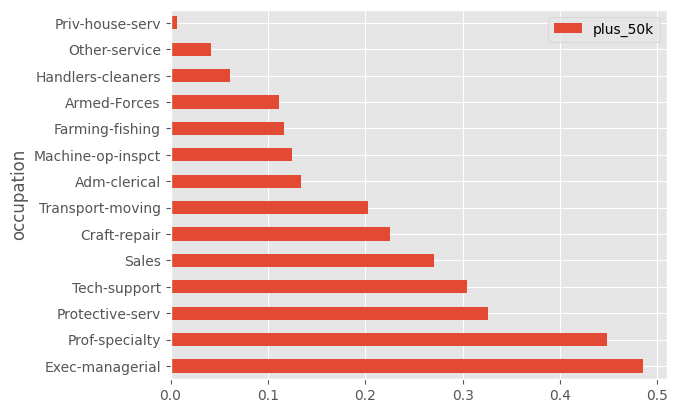

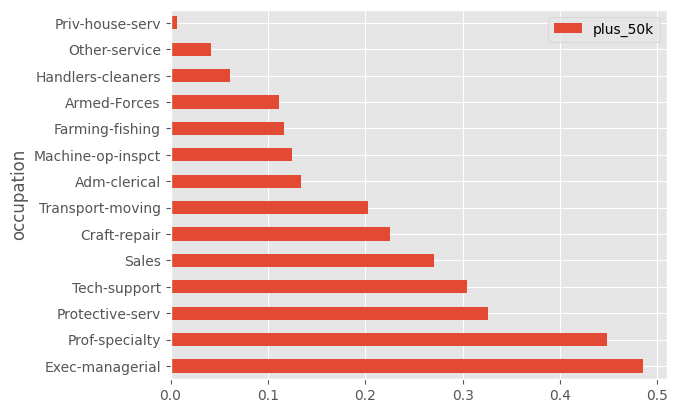

In [23]:
import matplotlib.pyplot as plt

# i like ggplot style
plt.style.use('ggplot')

# get simple plot on the pandas data
myplot = df_pandas.plot(kind='barh', x='occupation', y='plus_50k')

# display the plot (note - display() is a databricks function -
# more info on plotting in Databricks is here: https://docs.databricks.com/user-guide/visualizations/matplotlib-and-ggplot.html)
display(myplot.figure)

You can also easily get summary stats on a Spark DataFrame like below. [Here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html) is a nice blog post that has more examples.<br><br>So this is an example of why you might want to move from Spark SQL into DataFrames API as being able to just call describe() on the Spark DF is easier then trying to do the equivilant in Spark SQL.

In [24]:
# describe df
df_adult.select(df_adult['age'],df_adult['education_num']).describe().show()

+-------+------------------+-----------------+
|summary|               age|    education_num|
+-------+------------------+-----------------+
|  count|             30162|            30162|
|   mean|38.437901995888865|10.12131158411246|
| stddev|13.134664776856003|2.549994918856731|
|    min|                17|                1|
|    max|                90|               16|
+-------+------------------+-----------------+



### ML Pipeline - Logistic Regression vs Random Forest

Below we will create two [Spark ML Pipelines](https://spark.apache.org/docs/latest/ml-pipeline.html) - one that fits a logistic regression and one that fits a random forest. We will then compare the performance of each.

**Note**: A lot of the code below is adapted from [this example](https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html).

In [25]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]
stages = [] # stages in our Pipeline

for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    # encoder = OneHotEncoderEstimator(inputCol=categoricalCol + "Index", outputCol=categoricalCol + "classVec")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [26]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="income", outputCol="label")
stages += [label_stringIdx]

In [27]:
# Transform all features into a vector using VectorAssembler
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [28]:
# Create a Pipeline.
pipeline = Pipeline(stages=stages)
# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.
pipelineModel = pipeline.fit(df_adult)
dataset = pipelineModel.transform(df_adult)
# Keep relevant columns
selectedcols = ["label", "features"] + cols
dataset = dataset.select(selectedcols)
dataset.show()

+-----+--------------------+---+----------------+------+------------+-------------+--------------------+-----------------+-------------+------------------+------+------------+------------+--------------+--------------+------+
|label|            features|age|       workclass|fnlwgt|   education|education_num|      marital_status|       occupation| relationship|              race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+-----+--------------------+---+----------------+------+------------+-------------+--------------------+-----------------+-------------+------------------+------+------------+------------+--------------+--------------+------+
|  0.0|(96,[3,8,22,30,41...| 39|       State-gov| 77516|   Bachelors|           13|       Never-married|     Adm-clerical|Not-in-family|             White|  Male|        2174|           0|            40| United-States| <=50K|
|  0.0|(96,[1,8,21,29,40...| 50|Self-emp-not-inc| 83311|   Bachelors|           13|  Married-civ

In [29]:
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(testData.count())

21164
8998


In [30]:
from pyspark.sql.functions import avg

# get the rate of the positive outcome from the training data to use as a threshold in the model
training_data_positive_rate = trainingData.select(avg(trainingData['label'])).collect()[0][0]

print("Positive rate in the training data is {}".format(training_data_positive_rate))

Positive rate in the training data is 0.2512285012285012


#### Logistic Regression - Train

In [31]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# set threshold for the probability above which to predict a 1
lr.setThreshold(training_data_positive_rate)
# lr.setThreshold(0.5) # could use this if knew you had balanced data

# Train model with Training Data
lrModel = lr.fit(trainingData)

# get training summary used for eval metrics and other params
lrTrainingSummary = lrModel.summary

# Find the best model threshold if you would like to use that instead of the empirical positve rate
fMeasure = lrTrainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
lrBestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']

print("Best threshold based on model performance on training data is {}".format(lrBestThreshold))

Best threshold based on model performance on training data is 0.3515650614074174


#### GBM - Train

#### <span style="color:darkblue">Question 3</span>
1. Train a GBTClassifier on the training data, call the trained model 'gbModel'

In [33]:
### Question 3.1 Answer ###
from pyspark.ml.classification import GBTClassifier

# Create initial LogisticRegression model
gb = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)


# Train model with Training Data
gbModel = gb.fit(trainingData)

#### Logistic Regression - Predict

In [34]:
# make predictions on test data
lrPredictions = lrModel.transform(testData)

# display predictions
lrPredictions.select("label", "prediction", "probability").show()

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       1.0|[0.68177981621866...|
|  0.0|       1.0|[0.60025895777845...|
|  0.0|       1.0|[0.60011279479637...|
|  0.0|       1.0|[0.48071766669177...|
|  0.0|       0.0|[0.89987230336118...|
|  0.0|       1.0|[0.49965155795539...|
|  0.0|       1.0|[0.69212053758225...|
|  0.0|       1.0|[0.51905947154165...|
|  0.0|       1.0|[0.42337951785897...|
|  0.0|       1.0|[0.30263016389129...|
|  0.0|       1.0|[0.50310280995159...|
|  0.0|       0.0|[0.84341452792179...|
|  0.0|       0.0|[0.84264550359952...|
|  0.0|       0.0|[0.84327400751429...|
|  0.0|       0.0|[0.83409652787033...|
|  0.0|       0.0|[0.83040358535658...|
|  0.0|       0.0|[0.82999718998703...|
|  0.0|       0.0|[0.81742023679485...|
|  0.0|       0.0|[0.76177869193480...|
|  0.0|       0.0|[0.79376581277204...|
+-----+----------+--------------------+
only showing top 20 rows



### GBM - Predict

#### <span style="color:darkblue">Question 4</span>
1. Get predictions on the test data for your GBTClassifier. Call the predictions df 'gbPredictions'.

In [35]:
### Question 4.1 Answer ###

# make predictions on test data
gbPredictions = gbModel.transform(testData)

gbPredictions.show()

+-----+--------------------+---+---------+------+---------+-------------+------------------+--------------+------------+------------------+------+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
|label|            features|age|workclass|fnlwgt|education|education_num|    marital_status|    occupation|relationship|              race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|       rawPrediction|         probability|prediction|
+-----+--------------------+---+---------+------+---------+-------------+------------------+--------------+------------+------------------+------+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
|  0.0|(96,[0,6,21,27,40...| 26|  Private| 58426|  HS-grad|            9|Married-civ-spouse|Prof-specialty|     Husband|             White|  Male|           0|           0|            50| United-States| <=50K|[0

#### Logistic Regression - Evaluate

#### <span style="color:darkblue">Question 5</span>
1. Complete the print_performance_metrics() function below to also include measures of F1, Precision, Recall, False Positive Rate and True Positive Rate.

In [40]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

def print_performance_metrics(predictions):
  # Evaluate model
  evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
  auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
  aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
  print("auc = {}".format(auc))
  print("aupr = {}".format(aupr))

  # get rdd of predictions and labels for mllib eval metrics
  predictionAndLabels = predictions.select("prediction","label").rdd

  # Instantiate metrics objects
  binary_metrics = BinaryClassificationMetrics(predictionAndLabels)
  multi_metrics = MulticlassMetrics(predictionAndLabels)

  # Area under precision-recall curve
  print("Area under PR = {}".format(binary_metrics.areaUnderPR))
  # Area under ROC curve
  print("Area under ROC = {}".format(binary_metrics.areaUnderROC))
  # Accuracy
  print("Accuracy = {}".format(multi_metrics.accuracy))
  # Confusion Matrix
  print(multi_metrics.confusionMatrix())

  ### Question 5.1 Answer ###

  # F1
  print("F1 = {}".format(multi_metrics.fMeasure(1.0)))
  # Precision
  print("Precision = {}".format(multi_metrics.precision(1.0)))
  # Recall
  print("Recall = {}".format(multi_metrics.recall(1.0)))
  # FPR
  print("FPR = {}".format(multi_metrics.falsePositiveRate(1.0)))
  # TPR
  print("TPR = {}".format(multi_metrics.truePositiveRate(1.0)))


print_performance_metrics(lrPredictions)

auc = 0.9026230280706198
aupr = 0.7579913878682295
Area under PR = 0.548349153381663
Area under ROC = 0.819538167042451
Accuracy = 0.8098466325850189
DenseMatrix([[5450., 1357.],
             [ 354., 1837.]])
F1 = 0.6822655524605387
Precision = 0.5751408891671885
Recall = 0.8384299406663623
FPR = 0.19935360658146026
TPR = 0.8384299406663623


#### GBM - Evaluate

In [41]:
print_performance_metrics(gbPredictions)

auc = 0.9045193161360927
aupr = 0.7731494597781734
Area under PR = 0.6483171436303964
Area under ROC = 0.7530252001842279
Accuracy = 0.8506334741053567
DenseMatrix([[6421.,  386.],
             [ 958., 1233.]])
F1 = 0.647244094488189
Precision = 0.7615812229771464
Recall = 0.5627567320858056
FPR = 0.05670633171734979
TPR = 0.5627567320858056


## Cross Validation

For each model you can run the below comand to see its params and a brief explanation of each.

In [42]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [43]:
print(gb.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

#### Logisitic Regression - Param Grid

In [44]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
lrParamGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [2, 5])
             .build())

#### GBM - Param Grid

#### <span style="color:darkblue">Question 6</span>
1. Build out a param grid for the gb model, call it 'gbParamGrid'.

In [46]:
### Question 6.1 Answer ###

# Create ParamGrid for Cross Validation

gbParamGrid = (ParamGridBuilder()
    .addGrid(gb.maxDepth, [3, 5, 7])
    .addGrid(gb.maxBins, [32, 64])
    .addGrid(gb.maxIter, [50, 100])
    .addGrid(gb.stepSize, [0.05, 0.1, 0.2])
    .addGrid(gb.subsamplingRate, [1.0, 0.8])
    .build())


#### Logistic Regression - Perform Cross Validation

In [47]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

# set up an evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Create CrossValidator
lrCv = CrossValidator(estimator=lr, estimatorParamMaps=lrParamGrid, evaluator=evaluator, numFolds=2)

# Run cross validations
lrCvModel = lrCv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

In [48]:
# below approach to getting at the best params from the best cv model taken from:
# https://stackoverflow.com/a/46353730/1919374

# look at best params from the CV
print(lrCvModel.bestModel._java_obj.getRegParam())
print(lrCvModel.bestModel._java_obj.getElasticNetParam())
print(lrCvModel.bestModel._java_obj.getMaxIter())

0.01
0.0
5


#### GBM - Perform Cross Validation

#### <span style="color:darkblue">Question 7</span>
1. Perform cross validation of params on your 'gb' model.
1. Print out the best params you found.

In [49]:
### Question 7.1 Answer ###

# Create CrossValidator
gbCv = CrossValidator(estimator=gb, estimatorParamMaps=gbParamGrid, evaluator=evaluator, numFolds=2)

# Run cross validations
gbCvModel = gbCv.fit(trainingData)

In [52]:
### Question 7.2 Answer ###

# look at best params from the CV
print(gbCvModel.bestModel._java_obj.getMaxDepth())
print(gbCvModel.bestModel._java_obj.getMaxBins())
print(gbCvModel.bestModel._java_obj.getMaxIter())
print(gbCvModel.bestModel._java_obj.getStepSize())
print(gbCvModel.bestModel._java_obj.getSubsamplingRate())

3
64
100
0.2
1.0


#### Logistic Regression - CV Model Predict

In [53]:
# Use test set to measure the accuracy of our model on new data
lrCvPredictions = lrCvModel.transform(testData)

lrCvPredictions.show()

+-----+--------------------+---+---------+------+---------+-------------+------------------+--------------+------------+------------------+------+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
|label|            features|age|workclass|fnlwgt|education|education_num|    marital_status|    occupation|relationship|              race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|       rawPrediction|         probability|prediction|
+-----+--------------------+---+---------+------+---------+-------------+------------------+--------------+------------+------------------+------+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
|  0.0|(96,[0,6,21,27,40...| 26|  Private| 58426|  HS-grad|            9|Married-civ-spouse|Prof-specialty|     Husband|             White|  Male|           0|           0|            50| United-States| <=50K|[0

#### GBM - CV Model Predict

In [54]:
gbCvPredictions = gbCvModel.transform(testData)

gbCvPredictions.show()

+-----+--------------------+---+---------+------+---------+-------------+------------------+--------------+------------+------------------+------+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
|label|            features|age|workclass|fnlwgt|education|education_num|    marital_status|    occupation|relationship|              race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|       rawPrediction|         probability|prediction|
+-----+--------------------+---+---------+------+---------+-------------+------------------+--------------+------------+------------------+------+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
|  0.0|(96,[0,6,21,27,40...| 26|  Private| 58426|  HS-grad|            9|Married-civ-spouse|Prof-specialty|     Husband|             White|  Male|           0|           0|            50| United-States| <=50K|[0

#### Logistic Regression - CV Model Evaluate

In [55]:
print_performance_metrics(lrCvPredictions)

auc = 0.8987698383084476
aupr = 0.7388790641562599


/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Area under PR = 0.5385030941309312
Area under ROC = 0.8187950801310193
Accuracy = 0.8024005334518782
DenseMatrix([[5356., 1451.],
             [ 327., 1864.]])
F1 = 0.6770795495822739
Precision = 0.5622926093514329
Recall = 0.8507530807850296
FPR = 0.21316292052299105
TPR = 0.8507530807850296


#### GBM - CV Model Evaluate

In [56]:
print_performance_metrics(gbCvPredictions)

auc = 0.9232027639279425
aupr = 0.8181371752544012
Area under PR = 0.6916074476229501
Area under ROC = 0.7887095310979108
Accuracy = 0.8699711046899311
DenseMatrix([[6447.,  360.],
             [ 810., 1381.]])
F1 = 0.7024415055951171
Precision = 0.7932222860425043
Recall = 0.6303057964399817
FPR = 0.052886734244160426
TPR = 0.6303057964399817


#### Logistic Regression - Model Explore

In [57]:
print('Model Intercept: ', lrCvModel.bestModel.intercept)

Model Intercept:  -5.98609974707222


In [58]:
lrWeights = lrCvModel.bestModel.coefficients
lrWeights = [(float(w),) for w in lrWeights]  # convert numpy type to float, and to tuple
lrWeightsDF = spark.createDataFrame(lrWeights, ["Feature Weight"])
lrWeightsDF.show()

+--------------------+
|      Feature Weight|
+--------------------+
| 0.09260461609674801|
| -0.3111978093887234|
|-0.11224651330403951|
|-0.32523001274569024|
|  0.3435913522566778|
|  0.5285023452669972|
|-0.21129129561291835|
|-0.04740756034014...|
|    0.38080815940267|
|  0.6239480750844056|
| 0.03328292128927499|
|-0.43250378262644235|
|-0.05176355875046...|
| -0.4815021403394904|
| -0.8118198317474722|
|  1.1987212795401474|
| -0.6100803645894385|
|-0.49388826477351133|
|  1.1141548182633687|
|-0.37308473074751586|
+--------------------+
only showing top 20 rows



### Feature Importance

#### <span style="color:darkblue">Question 8</span>
1. Print out a table of feature_name and feature_coefficient from the Logistic Regression model.
<br><br>
Hint: Adapt the code from here: https://stackoverflow.com/questions/42935914/how-to-map-features-from-the-output-of-a-vectorassembler-back-to-the-column-name

In [77]:
### Question 8.1 Answer ###

# from: https://stackoverflow.com/questions/42935914/how-to-map-features-from-the-output-of-a-vectorassembler-back-to-the-column-name

from itertools import chain

lrModel = lrCvModel.bestModel

df_for_meta = trainingData
features_col = lrModel.getFeaturesCol()

meta = df_for_meta.schema[features_col].metadata
attrs = meta.get("ml_attr", {}).get("attrs", {})
all_attrs = list(chain.from_iterable(attrs.get(t, []) for t in ["binary", "numeric", "nominal"]))
ordered_feature_names = [a["name"] for a in sorted(all_attrs, key=lambda a: a["idx"])]

lrWeights = [float(w) for w in lrModel.coefficients]

rows = list(zip(ordered_feature_names, lrWeights))
lrWeightsDF = spark.createDataFrame(rows, ["Feature Name", "Feature Weight"])

lrWeightsDF.orderBy(F.desc(F.abs("Feature Weight"))).show(truncate=False)

+-------------------------------------------------+-------------------+
|Feature Name                                     |Feature Weight     |
+-------------------------------------------------+-------------------+
|native_countryclassVec_Nicaragua                 |-1.5337491220326345|
|native_countryclassVec_Columbia                  |-1.337995656071686 |
|native_countryclassVec_Cambodia                  |1.2463605204289523 |
|native_countryclassVec_Outlying-US(Guam-USVI-etc)|-1.2341502367660389|
|relationshipclassVec_Wife                        |1.224874564041714  |
|educationclassVec_Prof-school                    |1.1987212795401474 |
|native_countryclassVec_Peru                      |-1.1887537611138674|
|educationclassVec_Doctorate                      |1.1141548182633687 |
|native_countryclassVec_Dominican-Republic        |-1.0585398949981972|
|native_countryclassVec_Yugoslavia                |0.9433860353937807 |
|native_countryclassVec_Italy                     |0.93239646040

In [85]:
#gbCvFeatureImportance = pd.DataFrame([(name, gbCvModel.bestModel.featureImportances[idx]) for idx, name in attrs],columns=['feature_name','feature_importance'])

#print(gbCvFeatureImportance.sort_values(by=['feature_importance'],ascending =False))

In [86]:
fi = gbCvModel.bestModel.featureImportances

rows = [(a['name'], float(fi[a['idx']])) for a in all_attrs]

gbCvFeatureImportance = pd.DataFrame(rows, columns=['feature_name', 'feature_importance'])

print(gbCvFeatureImportance.sort_values(by='feature_importance', ascending=False).to_string(index=False))

                                     feature_name  feature_importance
        marital_statusclassVec_Married-civ-spouse            0.161255
                                     capital_gain            0.148602
                                              age            0.144768
                                    education_num            0.131298
                                     capital_loss            0.126865
                                   hours_per_week            0.084017
               occupationclassVec_Exec-managerial            0.030195
                        relationshipclassVec_Wife            0.019951
                 occupationclassVec_Other-service            0.016587
                                 sexclassVec_Male            0.012096
                      educationclassVec_Bachelors            0.011844
               workclassclassVec_Self-emp-not-inc            0.010835
               occupationclassVec_Farming-fishing            0.010052
                    

#### <span style="color:darkblue">Question 9</span>
1. Build and train a RandomForestClassifier and print out a table of feature importances from it.

In [88]:
### Question 9.1 Answer ###

from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=50, maxDepth=5, seed=42)

rfModel = rf.fit(trainingData)

fi = rfModel.featureImportances
rows = [(name, float(fi[idx])) for idx, name in enumerate(feature_names)]
rfFeatureImportance = pd.DataFrame(rows, columns=["feature_name", "feature_importance"])
print(rfFeatureImportance.sort_values(by="feature_importance", ascending=False).to_string(index=False))

                                     feature_name  feature_importance
                    educationclassVec_Prof-school        1.792405e-01
                   native_countryclassVec_Hungary        1.475986e-01
native_countryclassVec_Outlying-US(Guam-USVI-etc)        1.387691e-01
              occupationclassVec_Transport-moving        1.136523e-01
                            educationclassVec_9th        6.360557e-02
                  native_countryclassVec_Thailand        6.080160e-02
                  native_countryclassVec_Scotland        3.376822e-02
                  marital_statusclassVec_Divorced        3.221348e-02
               occupationclassVec_Farming-fishing        2.763463e-02
                      workclassclassVec_State-gov        2.528798e-02
                      workclassclassVec_Local-gov        2.502167e-02
             occupationclassVec_Handlers-cleaners        2.161387e-02
                  native_countryclassVec_Honduras        2.043112e-02
        marital_stat